# Topics
* [Essential and Fundmental matrices](#1)
* [Compute Fundmental matrix from corresponding points](#2)
* [Compute Epipolar lines](#2)

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

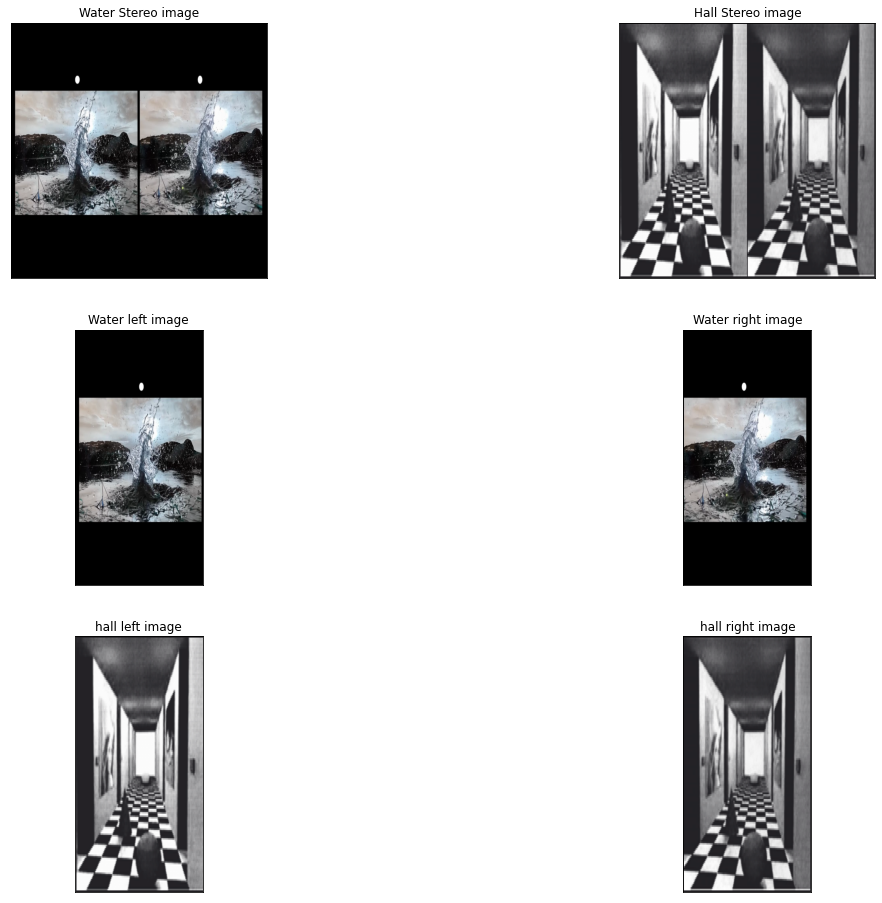

In [2]:
IMAGE_SHAPE = (700, 700)
water_im = cv.imread('udacity_images/stereo_water.jpg')
water_im = cv.resize(water_im, IMAGE_SHAPE)
hall_im = cv.imread('udacity_images/stereo_hall.png')
hall_im = cv.resize(hall_im, IMAGE_SHAPE, interpolation=cv.INTER_AREA)

center = IMAGE_SHAPE[0] // 2

water_left = water_im[:, :center]
water_right = water_im[:, center:]

hall_left = hall_im[:, :center]
hall_right = hall_im[:, center:]


fig, axs = plt.subplots(3, 2, figsize=(20,16))
axs[0, 0].imshow(water_im);axs[0, 0].set_title('Water Stereo image'), axs[0, 0].set_xticks([]), axs[0, 0].set_yticks([])
axs[0, 1].imshow(hall_im);axs[0, 1].set_title('Hall Stereo image'), axs[0, 1].set_xticks([]), axs[0, 1].set_yticks([])

imgs = [water_left, water_right, hall_left, hall_right]
labels = ['Water left image', 'Water right image', 'hall left image', 'hall right image']

for i, ax in enumerate(axs[1:].flatten()):
    ax.imshow(imgs[i]);ax.set_title(labels[i]),ax.set_xticks([]), ax.set_yticks([]);

<a id=1></a>
# Essential and Foundation Matrices

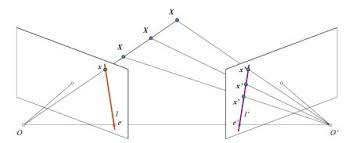

Geometry of stereo vision (Epipolar Geometry):
> In this part we have two images captured from different points of view, we want to map points in each image to their correspondece in the other image, in filters template (covered in [Udacity_Image processing_01](https://github.com/MahmoudEl-Husseni/Udacity-Introduction-to-Computer-Vision/blob/master/Udacity_Image%20processing_01.ipynb) I did some thing sort of like that but I was searching for point in every points of this photo and this led to finding multiple points have the same degree of similarity to ny point<br>
, So we need another way of mapping to shrink the scope of search.<br>

since $X_c$ in homogenous coordinates represents the vetor $OX$ and $x_{im}$ can be a projection to any point on this vector $OX$, we can't determine where exactly point $x_{im}$ in world coordintes to be able to find out where its correpondence in the other image, <br>instead we will use the vector $OX$ to determine a line in 
$\pi^{'}$ image, this line is called <font color='red'>**Epipolar Line**</font>, so we managed to reduce our scope of search to only search at this line (then we can perform filter template to get where exactly this point).

Our task here is to get this epipolar line using **Fundemental Matrix** in case of non calibrate cameras, or **Essential Matrix** in case of calibrated cameras 

### Essential Matrix: 
<font color='blue'>
$$ P_c^{'T}\:E\:P_c=0 , \:\:\: E= [T_x]\:R $$
</font>
$T$: the translation matrix between two images.<br>
$R$: the rotation matrix between two images.<br>

<font color='red' size=3>**Tip:**</font> We use Essential matrix in case of we have point in camera1 coordinates $P_c$, and want to get epipolar line in also camera1 coordinates $P_c^{'}$.

### Fundmetal Matrix: 
<font color='blue'>
$$ p^T_{im, right}\:F\:p_{im, left}=0 , \:\:\: F= K^{-1}_{right}\:E\:K^{-1}_{left} $$
</font>
$K$: The intrinsic calibration matrix<br>
$E$: Essential Matrix<br>

<font color='red' size=3>**Tip:**</font> We use Fundmental matrix in case of we have point in image1 coordinates $p_{im, left}$, and want to get epipolar line in image2 coordinates $p_{im, left}$.

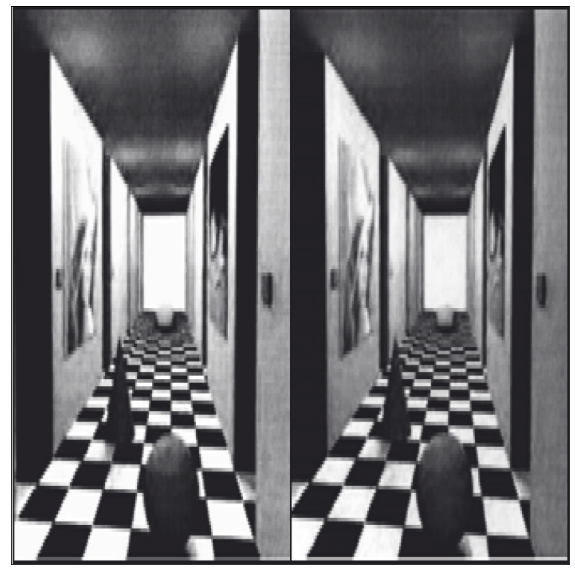

In [3]:
# first find some correspondences in two images to get Fundmental Matrix F

import plotly.graph_objects as go
import plotly.express as px

plt.figure(figsize=(10, 12))
plt.xticks([]), plt.yticks([])
plt.imshow(hall_im);

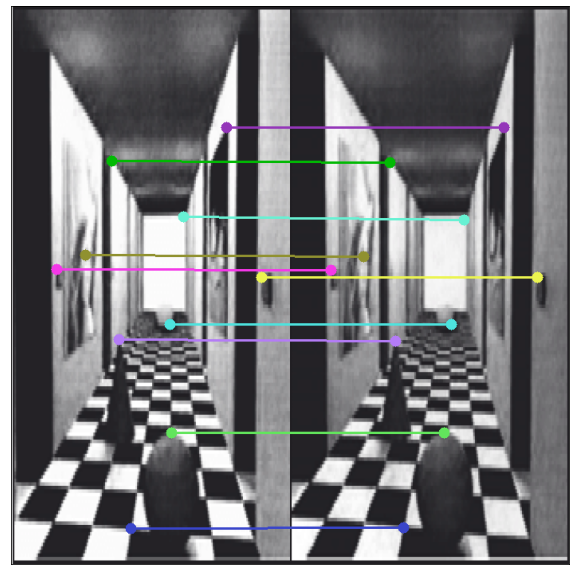

In [4]:
x, y = [93, 135, 314, 216, 199, 270, 126, 150, 57, 201], [312, 418, 340, 264, 399, 152, 194, 655, 330, 535]
x_, y_ = [442, 482, 660, 568, 552, 618, 475, 492, 401, 543], [314, 420, 340, 268, 399, 152, 196, 654, 331, 535]

x_right = [*map(lambda x : x-350, x_)]
y_right = y_

pts1 = np.int32([*zip(x, y)])
pts2 = np.int32([*zip(x_right, y_right)])

def plot_epilines_two_points(img, pts1, pts2):
    x, y = pts1
    x_, y_= pts2
    for i in range(len(x)):
        Color = tuple(np.random.randint(0, 255, 3).tolist())
        cv.circle(img, (x[i], y[i]), radius=7, color=Color, thickness=-1)
        cv.circle(img, (x_[i], y_[i]), color=Color, radius=7, thickness=-1)
        cv.line(img, (x[i], y[i]), (x_[i], y_[i]), color=Color, thickness=2)
    return img

painting = hall_im.copy()
img = plot_epilines_two_points(painting, (x, y), (x_, y_))
plt.figure(figsize=(10, 12))
plt.xticks([]), plt.yticks([])
plt.imshow(img);

<a id = 2></a>
# Compute Fundmental matrix from corresponding points
Now we have 10 corresponding points so we can compute the fundemental matrix using least squares:

$$p^T_{im, right}\:F\:p_{im, left}=0$$

so $$\begin{bmatrix} u^{(i)}_r & v^{(i)}_r & 1\end{bmatrix} \begin{bmatrix} f_{11} & f_{12} & f_{13} \\
f_{21} & f_{22} & f_{23} \\ f_{31} & f_{32} & f_{33}\end{bmatrix} \begin{bmatrix} u^{(i)}_l \\ v^{(i)}_l \\ 1\end{bmatrix} = 0$$

$$\begin{bmatrix} u^{(i)}_r  u^{(i)}_l & u^{(i)}_r  v^{(i)}_l & u^{(i)}_r &
                  v^{(i)}_r  u^{(i)}_l & v^{(i)}_r  v^{(i)}_l & v^{(i)}_r &
                  u^{(i)}_l & v^{(i)}_l & 1 \end{bmatrix}
\begin{bmatrix} f_{11} \\ f_{12} \\ f_{13} \\ f_{21} \\ f_{22} \\ f_{23} \\ f_{31} \\ f_{32} \\ f_{33} \end{bmatrix}  = 0$$
 
        In previous equation we need to find 9 values of fundmental matrix, but we won't solve this equation lineary because of noise in corresponding images, we will use least squares instead of it.

$$min_{\| \mathbf{f} \| = 1} \| \mathbf{Af} \|^2$$

However this equation doesn't enforce the rank constraints, so we need to enforce the rank of $f$ to be 2, so we will decompose $f$ to $SVD^T$ and assign the third value of $S$ (the smallest singluar value) to be 0

In [5]:
def compute_Fundmental_mat(x1, x2):

    x1 = np.matrix(np.append(pts1, np.ones((len(pts1), 1)), axis=1))
    x2 = np.matrix(np.append(pts2, np.ones((len(pts1), 1)), axis=1))
    n = len(x1)
    A_ = np.zeros((n, 9))
    for i in range(n):
        A_[i] = (x1[i].T @ x2[i]).flatten()
    
    
    S, V, D = np.linalg.svd(A_)
    F_ = D[-1].reshape(3, 3)

    s, v, d = np.linalg.svd(F_)
    v[2] = 0
    F_ = np.dot(s, np.diag(v).dot(d))
    
    return F_

F_ = compute_Fundmental_mat(pts1, pts2)
print(f'Fundmetnal matrix: \n {F_}')

Fundmetnal matrix: 
 [[ 6.48717667e-06 -1.82893555e-04  5.82617295e-02]
 [ 1.90222664e-04  5.48711165e-06 -8.14879979e-02]
 [-6.33355135e-02  7.65807081e-02  9.89994553e-01]]


<a id=3></a>
# Compute Epipolar lines

Currently we have Fundmetnal matrix, so we need to compute epipolar lines $p^{'}_{im, right}$, so line $l$ equation:

$$ l = p_{im, left}F$$ 
$$l = \begin{bmatrix} a & b & c \end{bmatrix},  \:\:\: l: ax + by + c = 0$$

In [6]:
get_points_from_line = lambda a, b, c, x : int((-a*x - c) / b)

def compute_epilines(pts, F_):
    n = len(pts)
    lines = np.zeros((n, 3))
    pts = np.matrix(np.append(pts, np.ones((n, 1)), axis=1))

    for i in range(n):
        pt = pts[i]
        lines[i] = np.dot(pt, F_)
        
    return lines
lines = compute_epilines(pts1, F_)

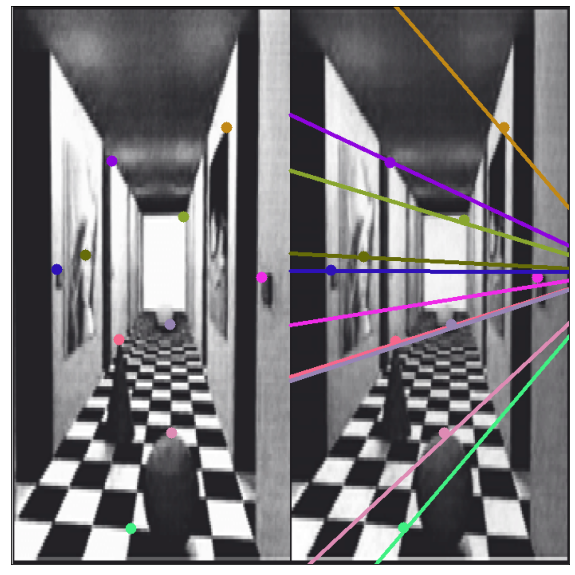

In [7]:
def plot_epilines_point_epiline(img, pts1, lines, pts2=None):
    x0, x1 = 0, img.shape[1]
    
    if pts2 is not None:
        
        for (pt1, (a, b, c)), pt2 in zip(zip(pts1, lines), pts2):
            
            Color = tuple(np.random.randint(0, 255, 3).tolist())
            y0, y1 = get_points_from_line(a, b, c, x0), get_points_from_line(a, b, c, x1)
            
            cv.line(img, (x0+350, y0), (x1+350, y1), color=Color, thickness=4)
            cv.circle(img, pt1, radius=7, color=Color, thickness=-1)
            cv.circle(img, (pt2[0]+350, pt2[1]), radius=7, color=Color, thickness=-1)
    else :
        for pt1, (a, b, c) in zip(pts1, lines):
            
            Color = tuple(np.random.randint(0, 255, 3).tolist())
            y0, y1 = get_points_from_line(a, b, c, x0), get_points_from_line(a, b, c, x1)
            
            cv.line(img, (x0+350, y0), (x1+350, y1), color=Color, thickness=2)
            cv.circle(img, pt1, radius=7, color=Color, thickness=-1)
    return img
painting = hall_im.copy()
img = plot_epilines_point_epiline(painting, pts1, lines, pts2)
plt.figure(figsize=(10, 12))
plt.xticks([]), plt.yticks([])
plt.imshow(img);

### Using opencv

In [8]:
F, mask = cv.findFundamentalMat(pts1, pts2,  cv.FM_LMEDS)

ppts1  = pts1[mask.ravel()==1]
ppts2 = pts2[mask.ravel()==1]

lines1 = cv.computeCorrespondEpilines(ppts2.reshape(-1, 1, 2), 2, F) # a, b, c -> ax+by+c = 0
lines1 = lines1.reshape(-1, 3)

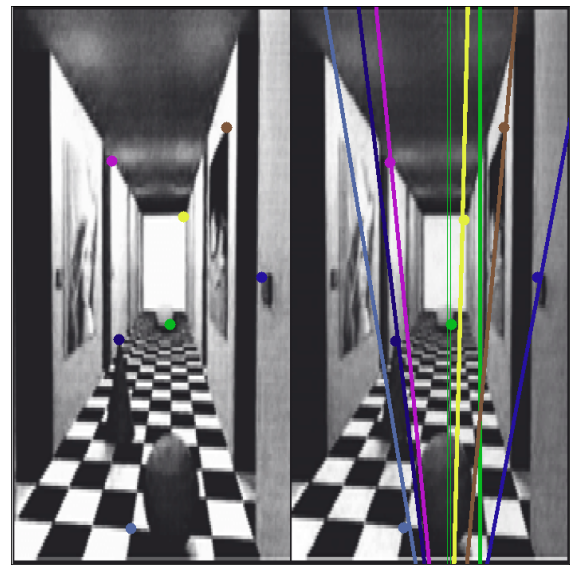

In [9]:
painting = hall_im.copy()
img = plot_epilines_point_epiline(painting, ppts1, lines1, pts2=ppts2)
plt.figure(figsize=(10, 12))
plt.xticks([]), plt.yticks([])
plt.imshow(img);

Random points and their correspondences:

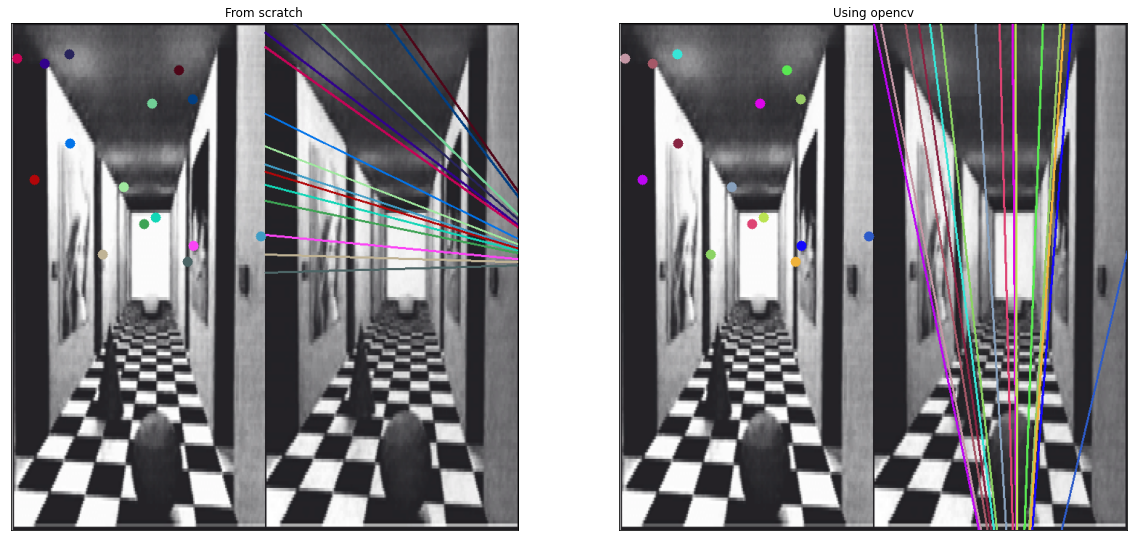

In [10]:
N_PTS = 15
pts_idx = np.random.randint(0, 350, (N_PTS, 2)) 
lines = compute_epilines(pts_idx, F)
painting = hall_im.copy()
img = plot_epilines_point_epiline(painting, pts_idx, lines)

lines_ = compute_epilines(pts_idx, F_)
painting = hall_im.copy()
img_ = plot_epilines_point_epiline(painting, pts_idx, lines_)


plt.figure(figsize=(20, 12))
plt.subplot(121);plt.title('From scratch'), plt.xticks([]), plt.yticks([])
plt.imshow(img_)

plt.subplot(122);plt.title('Using opencv'), plt.xticks([]), plt.yticks([])
plt.imshow(img);